# 8 - Metropolis Algorithm for the Ising Model

##### Imports:

In [179]:
import numpy as np
import random
import matplotlib.pyplot as plt
import scipy.integrate as integrate
import copy
import time

##### Configurate matplotlib settings

In [240]:
plt.style.use('ggplot')
plt.rcParams.update(
    {"text.usetex": True,
     'font.serif': 'Modern Roman',
     "figure.figsize": (10, 8),
     "legend.fontsize":16,
    "axes.titlesize" : 26,
    "axes.labelsize" : 28,
    "lines.linewidth": 3,
    "lines.markersize" : 10,
    "xtick.labelsize" : 24,
    "ytick.labelsize" : 24})

##### Functions:

In [2]:
def random_spins(N):
    '''Generate a N x N random lattice of spins, represented as a vector of length N^2.'''
    spins = [-1, 1]
    
    lattice = []
    for i in range(N**2):
        lattice.append(random.choice(spins))
    
    return lattice

In [3]:
def generate_exponentials(T):
    delta_E = [4, 8]
    exponentials = {}
    for E in delta_E:
        exponentials[str(E)] = np.exp(-E/T)
    return exponentials

In [4]:
def flip_spin(lattice, N, T):
    
    i = random.randint(0, N**2 - 1)
    s = lattice[i]
    
    # Initial energy
    E_i = 0
    E_i += - s*lattice[(i + N + N**2)%N**2]
    E_i += - s*lattice[(i -  N + N**2)%N**2]
        
    E_i += - s*lattice[(i + 1 + N**2)%N**2]
    E_i += - s*lattice[(i -  1 + N**2)%N**2]
    
    
    # Final energy:
    E_f = - E_i
    
    delta_E = -2*E_i
    
    if delta_E <= 0:
        lattice[i] = -s
        return lattice
    
    r = random.uniform(0, 1)
    key = str(delta_E)

    if r <= exponentials[key]:
        lattice[i] = -s
        return lattice
        
    return lattice

In [320]:
def compute_energy(lattice, N):
    '''Given a lattice, computes the energy per bond according to Hamiltonian for the Ising model.'''
    E = 0
    
    for i in range(len(lattice)):
        s = lattice[i]
        E += -s*lattice[(i + N + N**2)%N**2]
        E += -s*lattice[(i -  N + N**2)%N**2]
        
        E += -s*lattice[(i + 1 + N**2)%N**2]
        E += -s*lattice[(i -  1 + N**2)%N**2]
    
    # We counted double: divide by two AND return energy per bond (intensive variable)
    return E/(4*N**2)

In [6]:
def compute_magnetisation(lattice, N):
    return abs(np.sum(lattice))/(N**2)

In [321]:
def iteration_magnetisation(N, T, nsweeps, initial_state = False, sample_energies = False):
    '''Generates a N x N lattice or starts from a given lattice and performs the Metropolis algorithm nsweeps times.'''
    
    # --- Preparation for the iterations ---
    
    # Counter: how many MC steps are done
    counter = 0
    
    
    # If no initial state is given, generate a random lattice
    if initial_state == False:
        lattice = random_spins(N)
    else:
        lattice = copy.deepcopy(initial_state) # make a copy, such that things don't get messed up
    
    # Compute the exponentials for Metropolis (see report for details)
    exponentials = generate_exponentials(T)

    # Compute magnetisation of initial configuration
    m_list = [compute_magnetisation(lattice, N)]
    if sample_energies == True:
        energies = [compute_energy(lattice, N)]
    
    # --- Start the algorithm ---
    nreps = nsweeps*(N**2)
    print('Algorithm will do ', nreps, ' repetitions.')
    
    # Flip the spins and compute magnetisation each sweep    
    for i in range(nreps):
        new_lattice = flip_spin(lattice, N, T)
        counter += 1
        
        # To reduce computation time, only compute after a sweep is done: 1 sweep = N**2 MC steps
        if counter%N**2 == 0:
            m_list.append(compute_magnetisation(new_lattice, N))
            
            if sample_energies == True:
                energies.append(compute_energy(new_lattice, N))
        
        lattice = new_lattice
        
    # Return all the magnetisations and the final state, such that we can start from  the final state if we want to continue
    if sample_energies == False:
        return (m_list, lattice)
    
    if sample_energies == True:
        return (m_list, energies, lattice)

In [106]:
def exact_magnetisation(T):
    '''Computes the exact value of magnetisation, given T.'''
    return (1 - (np.sinh(2/T))**(-4))**(1/8)

## 8.1 - Magnetisation per spin

In [107]:
# Critical temperature
TC = 2/np.log(1 + np.sqrt(2))
print('The critical temperature is ', TC)

The critical temperature is  2.269185314213022


Set-up of the problem:

In [108]:
T = 2; N = 100; 

### Compute magnetisations per spin for T = 2 - this takes some time! Computations are put in comments below, since I saved the results to external files: load these files to get the plots, I will work with these in 8.2 below.

$\textbf{WARNING:}$ The Metropolis algorithm needs a lot of sweeps - this takes a lot of computation time!

The idea is to start from a low temperature, then gradually build up towards $T = 2$, in order to have a faster convergence.

$\textbf{FIRST RUN}$

In [286]:
# # Calculate magnetisation
# start = time.time()
# m_list, final = iteration_magnetisation(N, 0.1, 500) # temperature is 0.5, number of sweeps is 500
# end = time.time()
# print('Computation time was ', end - start, ' seconds.')

Algorithm will do  5000000  repetitions.
Computation time was  29.825369358062744  seconds.


In [287]:
import pickle

In [288]:
# ## Get only the magnetisation after each sweep - a sweep was 10^4 MC steps and we did 4000 sweeps

# ## Save magnetisation per sweep
# with open('msweeps1', 'wb') as f:
#     pickle.dump(m_list, f)

# ## Save final state
# with open('final1', 'wb') as f:
#     pickle.dump(final, f)

Once the file msweeps is made and stored, it can be loaded using pickle. Make sure pickle is imported, and the files have correct names.

In [289]:
with open('msweeps1', 'rb') as f:
    msweeps1 = pickle.load(f)
    
with open('final1', 'rb') as f:
    final1 = pickle.load(f)

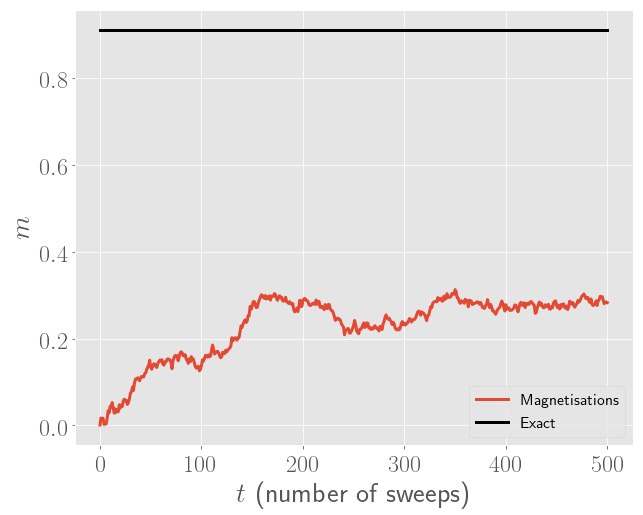

In [290]:
# Plot the result

plt.plot(msweeps1, label = 'Magnetisations')

# Plot exact value
t = np.arange(0, len(msweeps1), 1)
m_exact = exact_magnetisation(T) # T = 2
y = [m_exact for val in t]
plt.plot(t, y, color = 'black', label = 'Exact')

# Make fancy, save and show:
plt.xlabel(r'$t$ (number of sweeps)')
plt.ylabel(r'$m$')
plt.legend()
#plt.title('Magnetisation per spin, $T = $ %0.2f' %T)
#plt.savefig()
plt.show()

$\textbf{SECOND RUN}$

In [291]:
# # Calculate magnetisation
# start = time.time()
# m_list, final = iteration_magnetisation(N, 0.2, 500, initial_state = final1) # temperature is 1, number of sweeps is 600, start from previous one
# end = time.time()
# print('Computation time was ', end - start, ' seconds.')

Algorithm will do  5000000  repetitions.
Computation time was  29.60305619239807  seconds.


Save the results in a new file:

In [292]:
# ## Get only the magnetisation after each sweep - a sweep was 10^4 MC steps and we did 4000 sweeps

# ## Save magnetisation per sweep
# with open('msweeps2', 'wb') as f:
#     pickle.dump(m_list, f)

# ## Save final state
# with open('final2', 'wb') as f:
#     pickle.dump(final, f)

Load the results (afterwards)

In [293]:
with open('msweeps2', 'rb') as f:
    msweeps2 = pickle.load(f)
    
with open('final2', 'rb') as f:
    final2 = pickle.load(f)

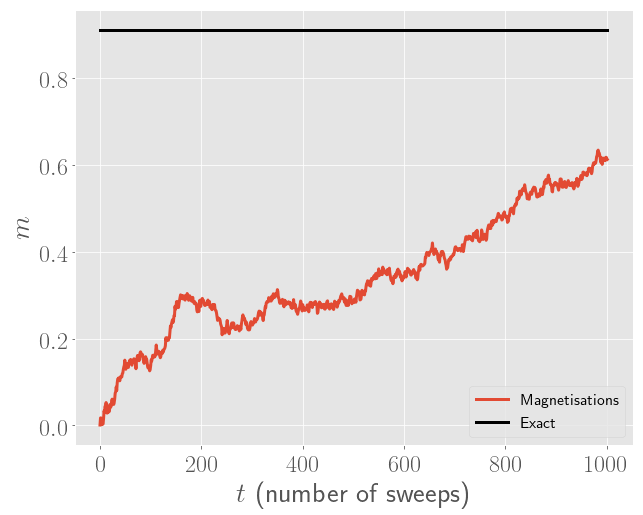

In [294]:
# Plot the result

plt.plot(msweeps1 + msweeps2, label = 'Magnetisations')

# Plot exact value
t = np.arange(0, len(msweeps1) + len(msweeps2), 1)
m_exact = exact_magnetisation(T) # T = 2
y = [m_exact for val in t]
plt.plot(t, y, color = 'black', label = 'Exact')

# Make fancy, save and show:
plt.xlabel(r'$t$ (number of sweeps)')
plt.ylabel(r'$m$')
plt.legend()
#plt.title('Magnetisation per spin, $T = $ %0.2f' %T)
#plt.xlim(490, 510)
#plt.savefig()
plt.show()

$\textbf{THIRD RUN}$

In [295]:
# # Calculate magnetisation
# start = time.time()
# m_list, final = iteration_magnetisation(N, 0.5, 500, initial_state = final2) # temperature is 1.5, number of sweeps is 500, start from previous one
# end = time.time()
# print('Computation time was ', end - start, ' seconds.')

Algorithm will do  5000000  repetitions.
Computation time was  27.81693720817566  seconds.


Save the results in a new file:

In [296]:
# ## Get only the magnetisation after each sweep - a sweep was 10^4 MC steps and we did 4000 sweeps

# ## Save magnetisation per sweep
# with open('msweeps3', 'wb') as f:
#     pickle.dump(m_list, f)

# ## Save final state
# with open('final3', 'wb') as f:
#     pickle.dump(final, f)

Load the results (afterwards)

In [297]:
with open('msweeps3', 'rb') as f:
    msweeps3 = pickle.load(f)
    
with open('final3', 'rb') as f:
    final3 = pickle.load(f)

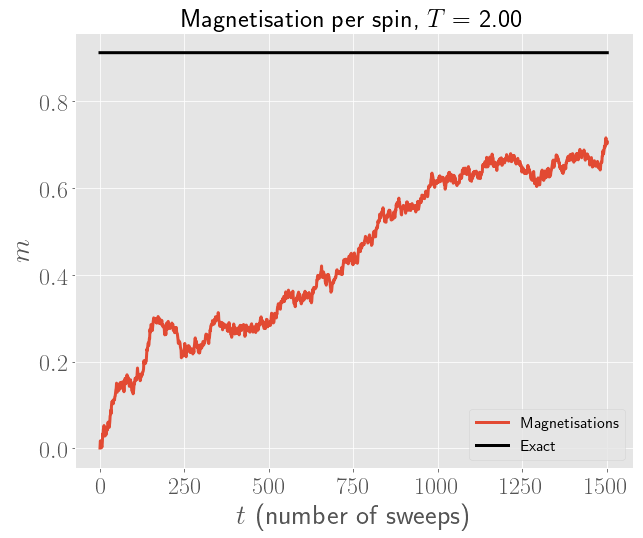

In [298]:
# Plot the result

plt.plot(msweeps1 + msweeps2 + msweeps3, label = 'Magnetisations')

# Plot exact value
t = np.arange(0, len(msweeps1) + len(msweeps2) + len(msweeps3), 1)
m_exact = exact_magnetisation(T) # T = 2
y = [m_exact for val in t]
plt.plot(t, y, color = 'black', label = 'Exact')

# Make fancy, save and show:
plt.xlabel(r'$t$ (number of sweeps)')
plt.ylabel(r'$m$')
plt.legend()
plt.title('Magnetisation per spin, $T = $ %0.2f' %T)
#plt.xlim(490, 510)
#plt.savefig()
plt.show()

We are now ready to start convering towards the expected magnetisation. That is, we now set $T = 2$ and let the algorithm start from the final state, and let it run for a longer period.

In [299]:
# # Calculate magnetisation
# start = time.time()
# # Temperature is final temp, number of sweeps is 2000, start from previous one
# m_list, final = iteration_magnetisation(N, 2, 2000, initial_state = final3) 
# end = time.time()
# print('Computation time was ', end - start, ' seconds.')

Algorithm will do  20000000  repetitions.
Computation time was  111.94761562347412  seconds.


In [300]:
### Get only the magnetisation after each sweep - a sweep was 10^4 MC steps and we did 4000 sweeps

### Save magnetisation per sweep
with open('msweeps4', 'wb') as f:
    pickle.dump(m_list, f)

### Save final state
with open('final4', 'wb') as f:
    pickle.dump(final, f)

Load the results (afterwards)

In [301]:
with open('msweeps4', 'rb') as f:
    msweeps4 = pickle.load(f)
    
with open('final3', 'rb') as f:
    final4 = pickle.load(f)

We have reached the end, so store all msweeps in a single list.

In [302]:
msweeps = msweeps1 + msweeps2 + msweeps3 + msweeps4

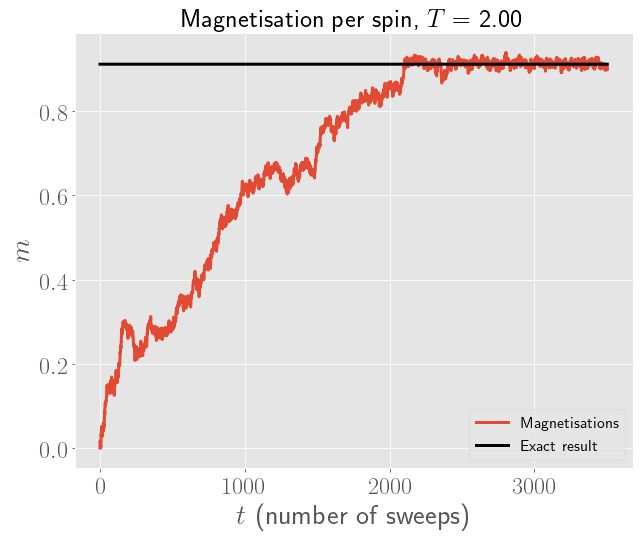

In [307]:
# Plot the result

plt.plot(msweeps, label = 'Magnetisations')

# Plot exact value

t = np.arange(0, len(msweeps), 1)
m_exact = exact_magnetisation(T) # T = 2
y = [m_exact for val in t]
plt.plot(t, y, color = 'black', label = 'Exact result')

# Make fancy, save and show:

plt.xlabel(r'$t$ (number of sweeps)')
plt.ylabel(r'$m$')
plt.legend()
plt.title('Magnetisation per spin, $T = $ %0.2f' %T)
#plt.savefig('ex8_magn_plot.pdf', bbox_inches = 'tight')
plt.show()

This looks good! Now we can start answering the questions.

## 8.2 - Estimate of the equilibration time

From the plot above, equilibrium is certainly reached after between 2000 and 2500 sweeps. This is between 500 and 1000 sweeps running at $T = 2$, starting from final3 as initial state.

## 8.3 - Histogram of the energies

The idea: the first 1500 sweeps and corresponding magnetisations correspond to the 'building up' of the temperature. However, the above code can sometimes be runned, and the magnetisations do not converge towards the correct exact value. Therefore, I will start from the lattice configuration final3, and then run the Metropolis algorithm at $T = 2$ a thousand times, and only then start sampling the energies at each sweep.

$\textbf{FIRST RUN: equilibration of the system}$

In [316]:
# Let the system equilibrate: give it 1000 sweeps time, to be sure!

# start = time.time()
# # Temperature is final temp, number of sweeps is 1000, start from final3
# m_list, final = iteration_magnetisation(N, 2, 1000, initial_state = final3) 
# end = time.time()
# print('Computation time was ', end - start, ' seconds.')

Algorithm will do  10000000  repetitions.
Computation time was  58.98706865310669  seconds.


Save the magnetisations and final state.

In [317]:
### Save magnetisation per sweep
# with open('msweeps5', 'wb') as f:
#     pickle.dump(m_list, f)

# ### Save final state
# with open('final5', 'wb') as f:
#     pickle.dump(final, f)

Load the data (afterwards):

In [318]:
with open('msweeps5', 'rb') as f:
    msweeps5 = pickle.load(f)
    
with open('final5', 'rb') as f:
    final5 = pickle.load(f)

Check graphically if equilibrium is indeed reached.

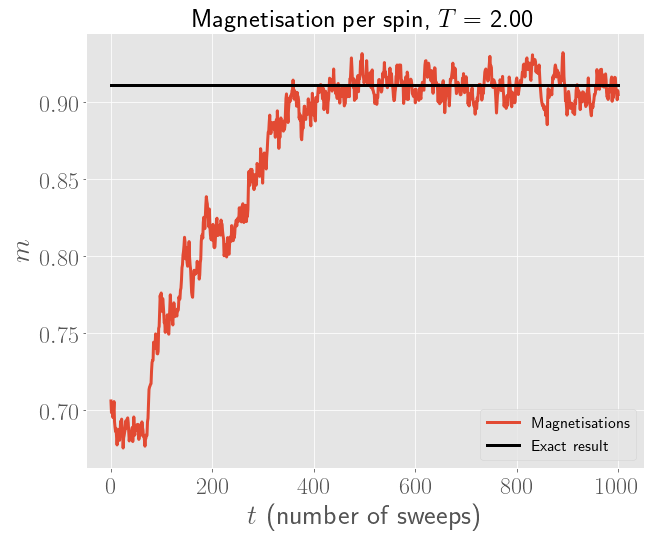

In [319]:
# Plot the result

plt.plot(msweeps5, label = 'Magnetisations')

# Plot exact value

t = np.arange(0, len(msweeps5), 1)
m_exact = exact_magnetisation(T) # T = 2
y = [m_exact for val in t]
plt.plot(t, y, color = 'black', label = 'Exact result')

# Make fancy, save and show:

plt.xlabel(r'$t$ (number of sweeps)')
plt.ylabel(r'$m$')
plt.legend()
plt.title('Magnetisation per spin, $T = $ %0.2f' %T)
plt.show()

Looks good! Now we also start sampling the energies for the histogram.

$\textbf{SECOND RUN: sample energies}$

In [322]:
# System is in equilibrium - sample energies

# start = time.time()
# # Temperature is final temp, number of sweeps is 1000, start from final5
# m_list, energies, final = iteration_magnetisation(N, 2, 1000, initial_state = final5, sample_energies = True) 
# end = time.time()
# print('Computation time was ', end - start, ' seconds.')

Algorithm will do  10000000  repetitions.
Computation time was  88.7622582912445  seconds.


Save the magnetisations and final state.

In [323]:
# ## Save magnetisation per sweep
# with open('msweeps6', 'wb') as f:
#     pickle.dump(m_list, f)

# ## Save final state
# with open('final6', 'wb') as f:
#     pickle.dump(final, f)
    
# ## Save final state
# with open('energies', 'wb') as f:
#     pickle.dump(energies, f)

Load the data (afterwards):

In [324]:
with open('msweeps6', 'rb') as f:
    msweeps6 = pickle.load(f)
    
with open('final6', 'rb') as f:
    final6 = pickle.load(f)
    
with open('energies', 'rb') as f:
    energies = pickle.load(f)    

Check how the magnetisations look.

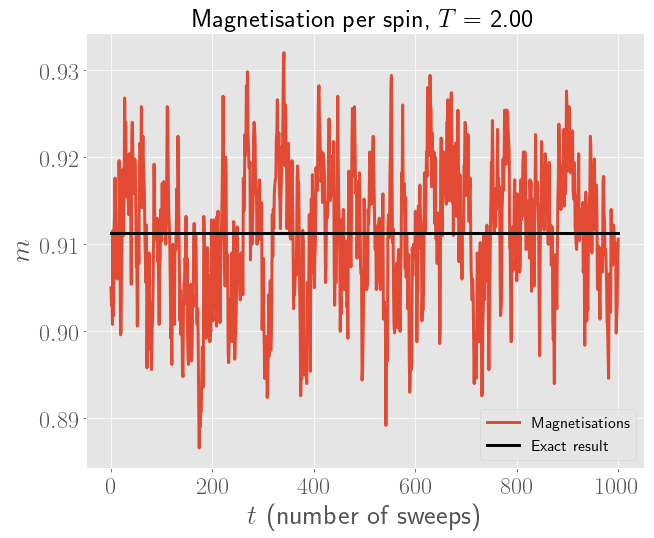

In [325]:
# Plot the result

plt.plot(msweeps6, label = 'Magnetisations')

# Plot exact value

t = np.arange(0, len(msweeps6), 1)
m_exact = exact_magnetisation(T) # T = 2
y = [m_exact for val in t]
plt.plot(t, y, color = 'black', label = 'Exact result')

# Make fancy, save and show:

plt.xlabel(r'$t$ (number of sweeps)')
plt.ylabel(r'$m$')
plt.legend()
plt.title('Magnetisation per spin, $T = $ %0.2f' %T)
plt.show()

In [433]:
print('The average magnetisation (after equilibration) is %0.4f while the exact value is %0.4f' %(np.mean(msweeps6), exact_magnetisation(2)))

The average magnetisation (after equilibration) is 0.9111 while the exact value is 0.9113


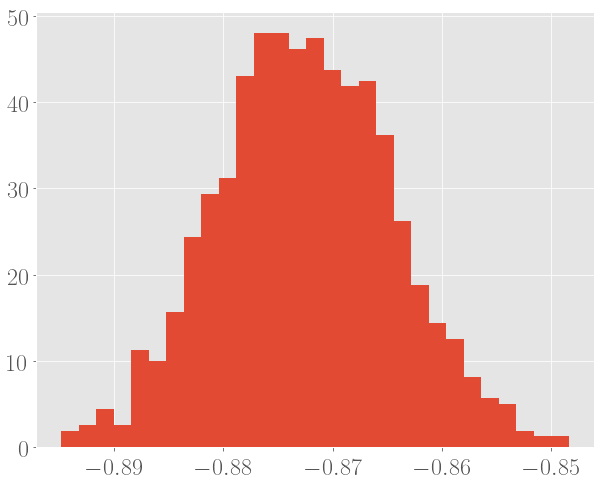

In [352]:
plt.hist(energies, density = True, bins = 29)
plt.show()

## 8.4 - Autocorrelation time

We do this for $T = 2$, $N = 100$, since we have this data already available, and hence do not have to start running above code again for different lattice sizes and different parameters.

The data in msweeps6 is obtained after equilibrium is reached. In that case, the sum in equation (92) in the lecture notes is a sum over msweeps.

In [388]:
def autocorrelation_function(m_list, t):
    '''Computes the autocorrelation function, see equation (92) in lecture notes.'''
    average_m = np.mean(m_list)
    s = 0 # the final sum
    counter = 0 # to get the average (count how many terms are in the sum)
    
    for i in range(len(m_list)):
        if i+t < len(m_list ): # index has to be well defined!
            s += (m_list[i] - average_m)*(m_list[i+t] - average_m)
            counter += 1
    
    return s/counter

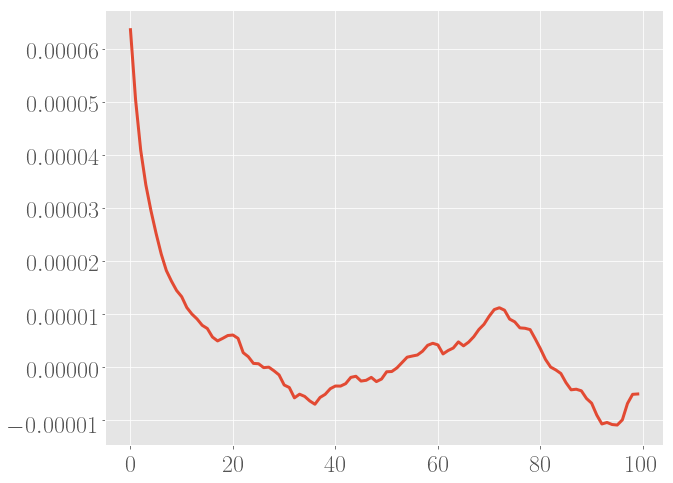

In [434]:
data = []

for t in range(100):
    data.append(autocorrelation_function(msweeps6, t))
plt.plot(data)
plt.show()    

Take the first 22 of above to fit an exponential.

In [416]:
data_sliced = data[:23]

We need scipy to fit.

In [417]:
import scipy

In [430]:
x = np.array([i for i in range(23)])

[a_opt, b_opt], pcov = scipy.optimize.curve_fit(lambda t,a,b: a*np.exp(-b*t), x ,  data_sliced,  p0=(0.00006, 10))
print('The optimal values for the parameters are a = %0.4f and b = %0.4f' %(a_opt, b_opt))
print('The covariance matrix for the parameters is ', pcov, ' hence errors are small.')

The optimal values for the parameters are a = 0.0001 and b = 0.1560
The covariance matrix for the parameters is  [[2.06543659e-12 5.55022472e-09]
 [5.55022472e-09 3.47321195e-05]]  hence errors are small.


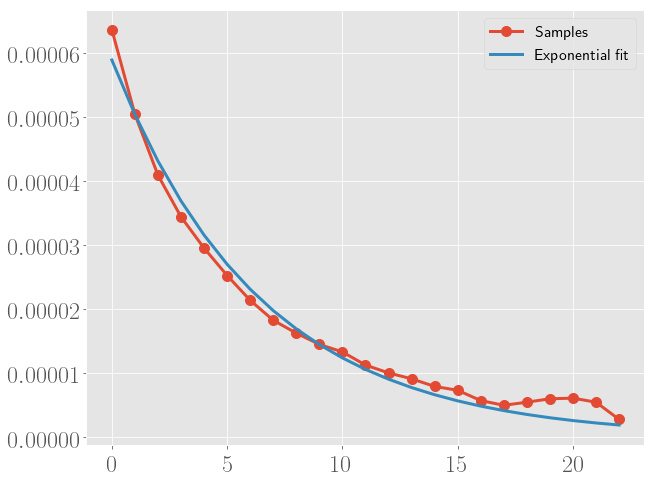

In [423]:
plt.plot(data_sliced, marker = 'o', label = 'Samples')
y = a_opt*np.exp(-b_opt*x)
plt.plot(x, y, label = 'Exponential fit')
plt.legend()
plt.show()

In [431]:
print('The autocorrelation time estimed from the fit is ', 1/b_opt)

The autocorrelation time estimed from the fit is  6.412011078903438
